In [97]:
from math import log
import pandas as pd 
import operator
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

In [138]:
#数据集
def createDataSet(path):
    data = pd.read_csv(path)
    data = data.drop(columns='编号')
    # data = data.drop(columns='密度')
    # data = data.drop(columns='含糖率')
    dataset = data.values.tolist()
    labels = data.columns.values
    labels = labels.tolist()
    #print(data)
    return dataset, labels  

### 信息增益

#### 熵
$$
 l(x)= -log_2^{P(x)}
$$

#### 信息熵

我们假设一个样本集合D中第k类样本所占比例为$p ( k ) p(k)p(k)（k=1,2，3…∣ y ∣）$，则D的信息熵可定义为：
$$
Ent(D)=-\sum_{k=1}^{\lvert y \rvert}(P(k)\times log_2^{P(k)})
$$
此为信息熵的计算公式，信息熵越小，数据就越纯。

#### 信息增益
假定一个数据集D，其中一个属性a有V个可能的取值${ a 1 , a 2 . . . a V a^{1},a^{2}...a^{V} }$，如果选定a为划分属性，那么会产生V个分支结点，其中第v个分支结点包含了D中所有在属性a上取值为$a^{v}$的样本，记$D^{v}$ 
信息增益计算公式：
$$
Gain(D,a) = Ent(D) - \sum_{k=1}^V \frac {\lvert D^v \rvert}{\lvert D\rvert} Ent(D^v)
$$



In [12]:
#计算信息熵
def calShannonEnt(dataset):
  rows = len(dataset)
  labelCounts = {}
  #提取分类标签
  for vec in dataset:
    label = vec[-1]
    if label not in labelCounts.keys():
      labelCounts[label] = 0
    labelCounts[label] += 1
  shannonEnt = 0.0
  for key in labelCounts:
    p = labelCounts[key] / rows
    shannonEnt += -1*(p*log(p,2))
  return shannonEnt

In [26]:
#划分数据集
def splitDataset(dataset,axis,value):
  retDataset = []
  for vec in dataset:
    #去掉axis这一列
    if vec[axis] == value:
      reducedVec = vec[:axis]
      reducedVec.extend(vec[axis+1:])
      retDataset.append(reducedVec)
  return retDataset

In [36]:
#选择最优特征
def chooseBestFeatureToSplit(dataset):
  numFeatures = len(dataset[0]) - 1
  baseEnt = calShannonEnt(dataset)
  print("dataset的信息熵",format(baseEnt,'.3f'))
  bestGain = 0.0
  bestFeature = -1
  for i in range(numFeatures):
    #提取第i个特征的所有类别
    featureList = [example[i] for example in dataset]
    featureSet = set(featureList)
    ent = 0.0
    for val in featureSet:
      subDataset = splitDataset(dataset,i,val)
      D = len(subDataset) / len(dataset)
      ent += D*calShannonEnt(subDataset)
    gain = baseEnt - ent 
    print(labels[i],"的信息增益",format(gain,'.3f'))
    if gain > bestGain:
      bestGain = gain
      bestFeature = i
  return bestFeature


In [37]:
#统计list中出现最多的分类
def majorityCnt(classList):
  classCount = {}
  for v in classList:
    if v not in classCount.keys():
      classCount[v] = 0
    classCount += 1
  sortedClassCount = sorted(classCount.items,key=operator.itemgetter(1),reverse=True) 
  return sortedClassCount[0][0]

In [122]:
#递归构建决策树
def createTree(dataset,labels,featureLabels):
  #获取全部数据的分类标签
  classList = [example[-1] for example in dataset]
  #数据的分类完全相同
  if classList.count(classList[0]) == len(classList):
    return classList[0]
  #遍历完所有特征后返回出现次数最多的分类标签
  if len(dataset[0])==1:
    return majorityCnt(classList)
  #获得信息增量最大的特征标签
  bestFeature = chooseBestFeatureToSplit(dataset)
  bestFeatureLabel = labels[bestFeature]
  print('最优的特征',bestFeatureLabel)
  #
  featureLabels.append(bestFeatureLabel)
  #建树
  tree = {bestFeatureLabel:{}}
  #删除最优特征标签
  del(labels[bestFeature])
  #获取最优特征标签的类别的集合
  featureValues = [example[bestFeature] for example in dataset]
  featureSet = set(featureValues)
  for val in featureSet:
    newLabels = labels[:]
    tree[bestFeatureLabel][val] = createTree(splitDataset(dataset,bestFeature,val),newLabels,featureLabels)
  return tree  


In [140]:
# 使用决策树进行分类任务
def classify(inputTree,labels,testVec):
  firstStr = next(iter(inputTree))
  secondDict = inputTree[firstStr]
  classLabel = ''
  idx = labels.index(firstStr)
  for key in secondDict.keys():
    if testVec[idx] == key:
      if type(secondDict[key]).__name__ == 'dict':#不是叶子节点
        classLabel = classify(secondDict[key],labels,testVec)
      else:#是叶子节点
        classLabel = secondDict[key]
  return classLabel 

In [139]:
dataset,labels = createDataSet('.\dataset\watermelon.csv')
featureLabels = []
tree = createTree(dataset,labels[:],featureLabels)

print(tree)

dataset的信息熵 0.998
色泽 的信息增益 0.108
根蒂 的信息增益 0.143
敲声 的信息增益 0.141
纹理 的信息增益 0.381
脐部 的信息增益 0.289
触感 的信息增益 0.006
密度 的信息增益 0.998
含糖率 的信息增益 0.998
最优的特征 密度
{'密度': {0.697: '是', 0.774: '是', 0.556: '是', 0.608: '是', 0.634: '是', 0.403: '是', 0.481: '是', 0.437: '是', 0.666: '否', 0.243: '否', 0.343: '否', 0.36: '否', 0.719: '否', 0.657: '否', 0.639: '否', 0.245: '否', 0.593: '否'}}


In [142]:
result = classify(tree,labels,['浅白','稍蜷','清脆','稍糊','平坦','软粘','0.697','0.46'])
if result == '是':
  print('好瓜')
if result == '否':
  print('坏瓜')

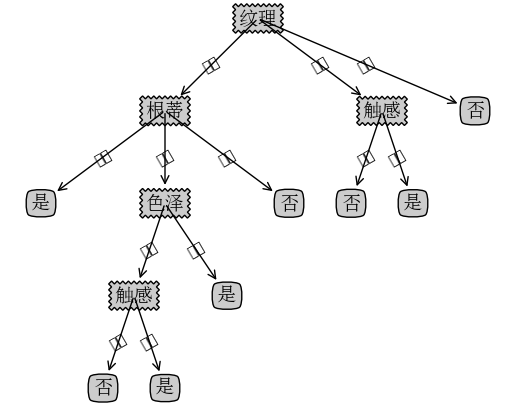

In [137]:
#实现数据可视化
#定义文本框和箭头格式
decisionNode=dict(boxstyle='sawtooth',fc='0.8')
leafNode=dict(boxstyle='round4',fc='0.8')
arrow_args=dict(arrowstyle='<-')
#设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
 
 
"""
函数说明:获取决策树叶子结点的数目
Parameters:
    myTree - 决策树
Returns:
    numLeafs - 决策树的叶子结点的数目
"""
def getNumLeafs(myTree):
    numLeafs = 0                   #初始化叶子
    # python3中myTree.keys()返回的是dict_keys,不在是list,所以不能使用myTree.keys()[0]的方法获取结点属性，
    # 可以使用list(myTree.keys())[0]
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]                      #获取下一组字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':     #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs +=1
    return numLeafs
 
 
"""
函数说明:获取决策树的层数
Parameters:
    myTree - 决策树
Returns:
    maxDepth - 决策树的层数
"""
def getTreeDepth(myTree):
    maxDepth = 0                                  #初始化决策树深度
    # python3中myTree.keys()返回的是dict_keys,不在是list,所以不能使用myTree.keys()[0]的方法获取结点属性，
    # 可以使用list(myTree.keys())[0]
    firstStr = next(iter(myTree))
    secondDict = myTree[firstStr]                          #获取下一个字典
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':         #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth      #更新层数
    return maxDepth
 
 
"""
函数说明:绘制结点
Parameters:
    nodeTxt - 结点名
    centerPt - 文本位置
    parentPt - 标注的箭头位置
    nodeType - 结点格式
"""
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    arrow_args = dict(arrowstyle="<-")                                          #定义箭头格式
    font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)        #设置中文字体
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',    #绘制结点
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args,fontproperties=font)
 
 
"""
函数说明:标注有向边属性值
Parameters:
    cntrPt、parentPt - 用于计算标注位置
    txtString - 标注的内容
"""
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]                               #计算标注位置
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)
 
 
"""
函数说明:绘制决策树
Parameters:
    myTree - 决策树(字典)
    parentPt - 标注的内容
    nodeTxt - 结点名
"""
def plotTree(myTree, parentPt, nodeTxt):
    decisionNode = dict(boxstyle="sawtooth", fc="0.8")                                    #设置结点格式
    leafNode = dict(boxstyle="round4", fc="0.8")                                          #设置叶结点格式
    numLeafs = getNumLeafs(myTree)                                                        #获取决策树叶结点数目，决定了树的宽度
    depth = getTreeDepth(myTree)                                                          #获取决策树层数
    firstStr = next(iter(myTree))                                                         #下个字典
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff) #中心位置
    plotMidText(cntrPt, parentPt, nodeTxt)                                                #标注有向边属性值
    plotNode(firstStr, cntrPt, parentPt, decisionNode)                                    #绘制结点
    secondDict = myTree[firstStr]                                                         #下一个字典，也就是继续绘制子结点
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD                                   #y偏移
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':                 #测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
            plotTree(secondDict[key],cntrPt,str(key))              #不是叶结点，递归调用继续绘制
        else:                                                      #如果是叶结点，绘制叶结点，并标注有向边属性值
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
 
 
"""
函数说明:创建绘制面板
Parameters:
    inTree - 决策树(字典)
"""
def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')                               #创建fig
    fig.clf()                                                            #清空fig
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)          #去掉x、y轴
    plotTree.totalW = float(getNumLeafs(inTree))                         #获取决策树叶结点数目
    plotTree.totalD = float(getTreeDepth(inTree))                        #获取决策树层数
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;           #x偏移
    plotTree(inTree, (0.5,1.0), '')                                      #绘制决策树
    plt.show()

createPlot(tree)
#['浅白','稍蜷','清脆','稍糊','平坦','软粘']